In [2]:
import pandas as pd

In [3]:
data = pd.read_csv("WA_Marketing-Campaign.csv")

In [4]:
data.describe()

,MarketID,LocationID,AgeOfStore,Promotion,week,SalesInThousands
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,5.715328,479.656934,8.503650,2.029197,2.500000,53.466204
std,2.877001,287.973679,6.638345,0.810729,1.119055,16.755216
min,1.000000,1.000000,1.000000,1.000000,1.000000,17.340000
25%,3.000000,216.000000,4.000000,1.000000,1.750000,42.545000
50%,6.000000,504.000000,7.000000,2.000000,2.500000,50.200000
75%,8.000000,708.000000,12.000000,3.000000,3.250000,60.477500
max,10.000000,920.000000,28.000000,3.000000,4.000000,99.650000


In [5]:
data.isna().any()

MarketID            False
MarketSize          False
LocationID          False
AgeOfStore          False
Promotion           False
week                False
SalesInThousands    False
dtype: bool

Perfect all good!

## Visulizations 

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

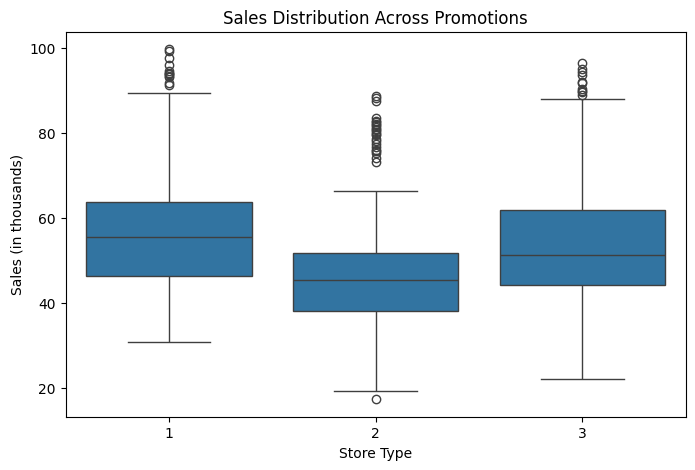

In [24]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="Promotion", y="SalesInThousands", data=data)

# Customize Plot
plt.title("Sales Distribution Across Promotions")
plt.xlabel("Store Type")
plt.ylabel("Sales (in thousands)")

plt.show()


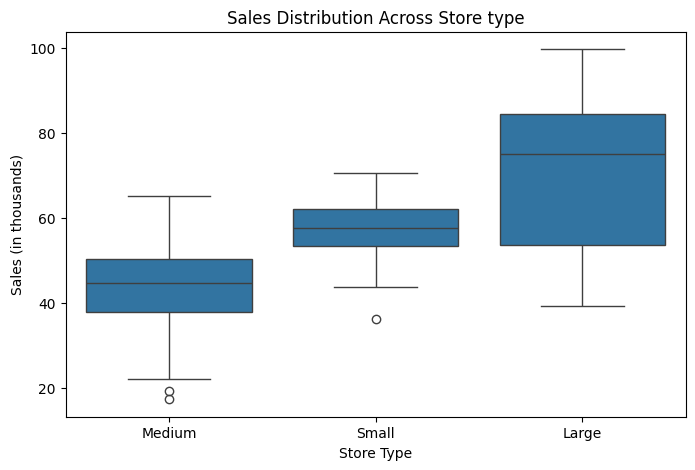

In [23]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="MarketSize", y="SalesInThousands", data=data)

# Customize Plot
plt.title("Sales Distribution Across Store type")
plt.xlabel("Store Type")
plt.ylabel("Sales (in thousands)")

plt.show()


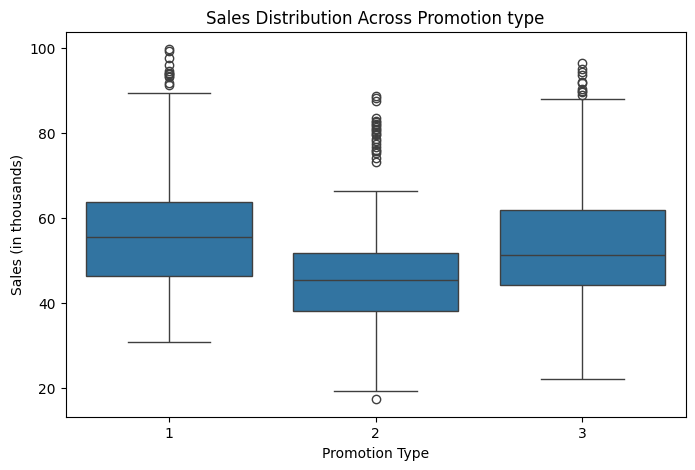

In [26]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="Promotion", y="SalesInThousands", data=data)

# Customize Plot
plt.title("Sales Distribution Across Promotion type")
plt.xlabel("Promotion Type")
plt.ylabel("Sales (in thousands)")

plt.show()

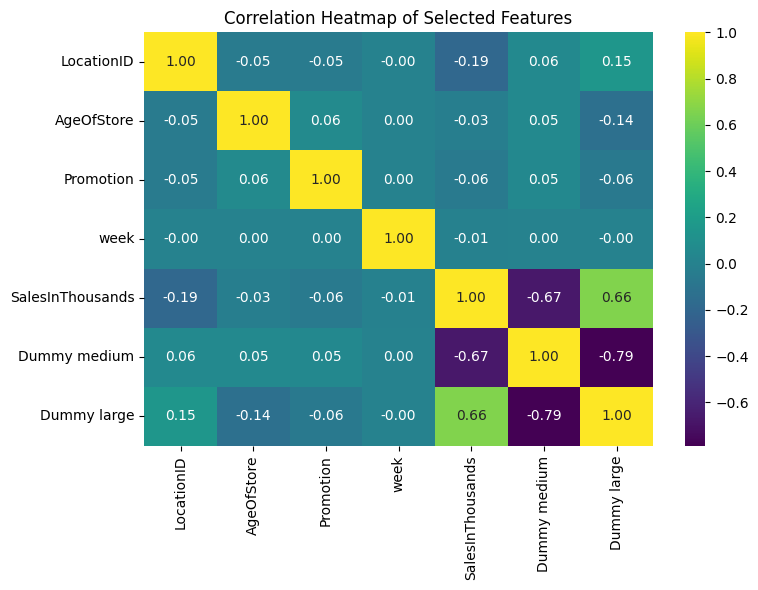

In [9]:
data["Dummy medium"] = (data["MarketSize"] == "Medium").astype(int)
data["Dummy large"] = (data["MarketSize"] == "Large").astype(int)

plt.figure(figsize=(8, 6))

sns.heatmap(data.iloc[:, 2:].corr(), annot=True, fmt=".2f", cmap="viridis")
# Title
plt.title("Correlation Heatmap of Selected Features")
plt.tight_layout()
plt.show()

I think the obvious takeaway here is that. Both Medium and Large have an impact on SalesInThousands so let's make sure we take that into account during our AB testing

In [13]:
data["Promotion"].value_counts()

Promotion
3    188
2    188
1    172
Name: count, dtype: int64

In [15]:
data["MarketSize"].value_counts()

MarketSize
Medium    320
Large     168
Small      60
Name: count, dtype: int64

In [17]:
data.groupby("MarketSize")["Promotion"].value_counts()

MarketSize  Promotion
Large       2             64
            1             56
            3             48
Medium      3            116
            2            108
            1             96
Small       3             24
            1             20
            2             16
Name: count, dtype: int64

Seems Balanced!

## Statistics
Before we can fully get started we need to a hypothesis

Null hypothesis $H_0$ = all promotions are the same

Alternativ hypothesis $H_A$ = Some promotions are better

In [ ]:
from scipy import stats
from scipy.stats import mannwhitneyu

sales_promo1 = data[data["Promotion"] == 1]["SalesInThousands"]
sales_promo2 = data[data["Promotion"] == 2]["SalesInThousands"]
sales_promo3 = data[data["Promotion"] == 3]["SalesInThousands"]

(21.953485793080677, 6.765849261408714e-10)

In [65]:
def ttest(data: list):
    assert len(data) == 3 # if wrong length

    dictionary = {}
    for i in range(len(data) - 1):
        for j in range(i + 1, len(data)):
        
            U1, p_value = stats.ttest_ind(data[i], data[j])
            key = f"Promo{i+1} vs Promo{j+1}"  # create key
            dictionary[key] = p_value  # Store p-value in the dictionary
    return dictionary
    
biglist = (sales_promo1, sales_promo2, sales_promo3)
results_ttest = ttest(biglist)

In [66]:
results_ttest

{'Promo1 vs Promo2': 3.5506696512134566e-10,
 'Promo1 vs Promo3': 0.12079667272313277,
 'Promo2 vs Promo3': 1.5628943036277377e-06}

In [61]:
def MannwhitneyU(data: list) -> dict:
    assert len(data) == 3 # if wrong length

    dictionary = {}
    for i in range(len(data) - 1):
        for j in range(i + 1, len(data)):
        
            U1, p_value = mannwhitneyu(data[i], data[j])
            key = f"Promo{i+1} vs Promo{j+1}"  # create key
            dictionary[key] = p_value  # Store p-value in the dictionary

    return dictionary

biglist = (sales_promo1, sales_promo2, sales_promo3)
results_MannwhitneyU = MannwhitneyU(biglist)

In [62]:
results_MannwhitneyU

{'Promo1 vs Promo2': 5.845935246838518e-12,
 'Promo1 vs Promo3': 0.035084095693231204,
 'Promo2 vs Promo3': 1.1970084441651803e-07}

With the t-test we can not reject the null hypthesis that the difference between Promo1 and Promo 3

With the MannwhitneyU non-parametric test we can reject the null hypothesis

Slight issue here is that this is the birdseye view, instead let's delve into the details and see if the results are any different for store sizes

In [49]:
df_small = data[data["MarketSize"] == "Small"]
df_medium = data[data["MarketSize"] == "Medium"]
df_large = data[data["MarketSize"] == "Large"]

In [72]:
def create_dataframe(dataframe):
    """Create a dataframe"""
    dataframe1 = dataframe[dataframe["Promotion"] == 1]["SalesInThousands"]
    dataframe2 = dataframe[dataframe["Promotion"] == 2]["SalesInThousands"]
    dataframe3 = dataframe[dataframe["Promotion"] == 3]["SalesInThousands"]

    return dataframe1, dataframe2, dataframe3

# Turn them into dataframes
df_small1, df_small2, df_small3 = create_dataframe(df_small)
df_medium1, df_medium2, df_medium3 = create_dataframe(df_medium)
df_large1, df_large2, df_large3 = create_dataframe(df_large)

# Turn them into lists
list_small = (df_small1, df_small2, df_small3)
list_medium = (df_medium1, df_medium2, df_medium3)
list_large = (df_large1, df_large2, df_large3)

In [ ]:
results_small1 = MannwhitneyU(list_small)
results_small2 = ttest(list_small)

results_small1, results_small2

({'Promo1 vs Promo2': 4.927166796986004e-05,
  'Promo1 vs Promo3': 0.7954179576841569,
  'Promo2 vs Promo3': 5.8957036810791074e-05},
 {'Promo1 vs Promo2': 1.2753118409770983e-05,
  'Promo1 vs Promo3': 0.6810867067433423,
  'Promo2 vs Promo3': 1.7059958706547652e-05})

We cannot reject the Null hypothesis between promo 1 and promo 2 for small stores

In [74]:
results_medium = MannwhitneyU(list_medium)
results_medium1 = ttest(list_medium)

results_medium, results_medium1

({'Promo1 vs Promo2': 6.694419331697923e-10,
  'Promo1 vs Promo3': 0.10559079188934166,
  'Promo2 vs Promo3': 1.21452083281794e-07},
 {'Promo1 vs Promo2': 1.1261780419231885e-11,
  'Promo1 vs Promo3': 0.04939721833170492,
  'Promo2 vs Promo3': 5.470518861290384e-08})

We cannot reject the Null hypothesis between promo 1 and promo 2 for small stores

In [75]:
results_large = MannwhitneyU(list_large)
results_large1 = ttest(list_large)

results_large, results_large1

({'Promo1 vs Promo2': 1.611787855020616e-07,
  'Promo1 vs Promo3': 0.9765916069490451,
  'Promo2 vs Promo3': 1.496399158780798e-08},
 {'Promo1 vs Promo2': 7.854262204192483e-07,
  'Promo1 vs Promo3': 0.5063120169025387,
  'Promo2 vs Promo3': 5.7276273822092916e-08})

We cannot reject the Null hypothesis between promo 1 and promo 2 for small stores